In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name': model_name,
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_size': 128,
    'num_filters': 100,
    'dropout_rate': 0.5,
    'hidden_dim': 250,
    'output_dim': 1
}

In [6]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1, output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, activation='relu', 
                                        kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                        #MaxNorm(max_value=3.) 커널의 가중치값이 최대 값 3을 넘지 않게 설정
                          for kernel_size in [3,4,5]]
        
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dim'],
                           activation='relu',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dim'],
                           activation='sigmoid',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [9]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                    callbacks=[early_stopping])

Epoch 1/10
264/264 [==============================] - 39s 141ms/step - loss: 0.4596 - accuracy: 0.7737 - val_loss: 0.3922 - val_accuracy: 0.8208
Epoch 2/10
264/264 [==============================] - 13s 48ms/step - loss: 0.3533 - accuracy: 0.8451 - val_loss: 0.3866 - val_accuracy: 0.8269
Epoch 3/10
264/264 [==============================] - 13s 48ms/step - loss: 0.3013 - accuracy: 0.8722 - val_loss: 0.3930 - val_accuracy: 0.8271
Epoch 4/10
264/264 [==============================] - 13s 49ms/step - loss: 0.2554 - accuracy: 0.8939 - val_loss: 0.4145 - val_accuracy: 0.8243
Epoch 5/10
264/264 [==============================] - 13s 48ms/step - loss: 0.2224 - accuracy: 0.9093 - val_loss: 0.4434 - val_accuracy: 0.8206


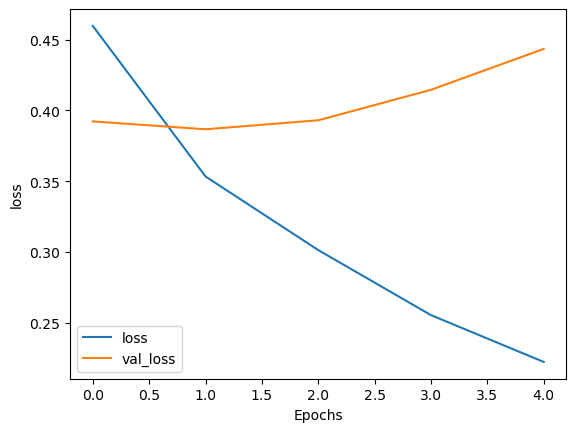

In [11]:
plot_graphs(history, 'loss')

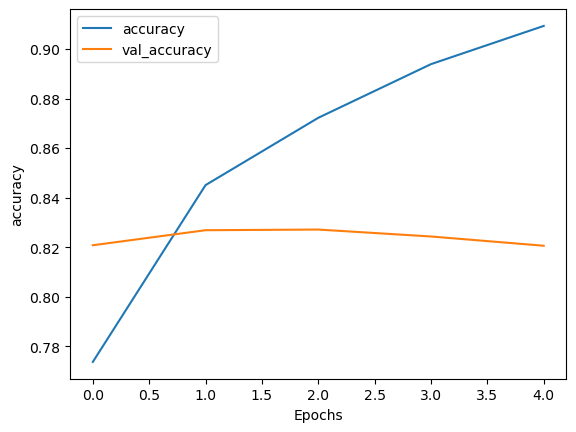

In [12]:
plot_graphs(history, 'accuracy')

In [13]:
test_input = np.load(open('data-in/nsmc_test_input.npy', 'rb'))
test_label_data = np.load(open('data-in/nsmc_test_label.npy', 'rb'))
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.4379 - accuracy: 0.8230


[0.43786320090293884, 0.8229600191116333]